<a href="https://colab.research.google.com/github/sktoyo/GraphConvolutionalNetwork/blob/main/dgl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# in colab environment
!pip install dgl-cu101
!python -m dgl.backend.set_default_backend tensorflow
import os
os.chdir('/content/drive/My Drive/Research/disease gene prediction/python project/src')

2021-03-06 09:49:44.170739: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using backend: tensorflow
2021-03-06 09:49:48.483025: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-06 09:49:48.498909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-06 09:49:48.552764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-06 09:49:48.553460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-03-06 09:49:48.553520: I tensorflow/stream_executor/

# Import Libraries

In [2]:
import pandas as pd
import pickle
import networkx as nx
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import itertools
import dgl
import random
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from tensorflow.keras import layers
import dgl.function as fn
from dgl.nn.tensorflow import edge_softmax, GATConv
from dgl.nn.tensorflow import GraphConv

Using backend: tensorflow


## Resource paths

In [3]:
resource_path = '../../../Resources/'
Humannet_path = resource_path + 'humannet/'
oncoKB_path = resource_path + 'OncoKB/'
cosmic_path = resource_path + 'CGC cosmic/'
ncbi_path = resource_path + 'ncbi gene info/'

In [4]:
expression_path = '../data/expression_data/TCGA-BRCA/'
mutation_path = '../data/mutation data/'

In [5]:
preprocess_dir = 'preprocessing/'

# Experiment Data

In [6]:
expression_data = pd.read_csv(expression_path + 'TCGA_BRCA_TPM_symbol.tsv', sep='\t', index_col=0)
mutation_data = pd.read_csv(mutation_path + 'TCGA_BRCA_mutation_feature.txt', sep='\t', index_col=0)

In [7]:
mutation_data = mutation_data.drop(columns=['gene length'])

In [8]:
input_data = pd.merge(expression_data, mutation_data, left_index=True, right_index=True).drop_duplicates()

In [9]:
experiment_gene_list = input_data.index.to_list()

##Create Network from Humannet DB

In [10]:
gene_id_info = pd.read_csv(ncbi_path + 'Homo_sapiens.gene_info.txt', sep='\t')

In [11]:
gene_id_info = gene_id_info.drop(columns=['#tax_id'])

In [12]:
gene_id_info = gene_id_info[['GeneID', 'Symbol']]

In [13]:
entrez_id = gene_id_info['GeneID'].tolist()
entrez_symbol = gene_id_info['Symbol'].tolist()
entrez_id_dict = dict()

for i, id in enumerate(entrez_id):
  entrez_id_dict[str(id)] = entrez_symbol[i]

In [ ]:
humannet_DF = pd.read_csv(Humannet_path + 'HumanNet-XN.tsv', sep='\t')
humannet_DF = humannet_DF.astype('str')

# preprocessing of changed entrezIDs
humannet_DF = humannet_DF[humannet_DF.EntrezGeneID1 != '10896']
humannet_DF = humannet_DF[humannet_DF.EntrezGeneID2 != '10896']

humannet_DF = humannet_DF[humannet_DF.EntrezGeneID1 != '285464']
humannet_DF = humannet_DF[humannet_DF.EntrezGeneID2 != '285464']

humannet_DF = humannet_DF[humannet_DF.EntrezGeneID1 != '729574']
humannet_DF = humannet_DF[humannet_DF.EntrezGeneID2 != '729574']

humannet_genes = list(set(humannet_DF['EntrezGeneID1'].to_list() + humannet_DF['EntrezGeneID2'].to_list()))
humannet_genes = [geneid for geneid in humannet_genes if geneid in entrez_id_dict]

humannet_edges = list()
humannet_edges_feature = list()

# total size is 
for index, row in tqdm(humannet_DF.iterrows()):
  gene1 = entrez_id_dict[row['EntrezGeneID1']]
  gene2 = entrez_id_dict[row['EntrezGeneID2']]
  if gene1 in experiment_gene_list and gene2 in experiment_gene_list:
    humannet_edges.append([gene1, gene2])
    humannet_edges_feature.append(row['LLS'])

# remove self loop, remove duplicated reverse edges, make bidirectionality
humannet_edges = list(humannet_edges for humannet_edges,_ in itertools.groupby(humannet_edges))
humannet_edges = [edge for edge in humannet_edges if edge[0] != edge[1]]
humannet_edges_reverse = [[edge[1], edge[0]] for edge in humannet_edges]
humannet_edges = humannet_edges + humannet_edges_reverse
humannet_edges = list(set(map(tuple,humannet_edges)))

## Join gene list btw network and exp

In [ ]:
humannet_genes = set([edge[0] for edge in humannet_edges])
input_data = input_data[input_data.index.isin(list(humannet_genes))]

In [ ]:
input_data = input_data.sort_index()

In [ ]:
gene_list = input_data.index.to_list()

In [ ]:
gene_index_dict = dict()
with open(preprocess_dir + 'gene_index.tsv', 'w') as f:
  for i in range(len(gene_list)):
    gene_info = [str(i), gene_list[i]]
    gene_index_dict[gene_list[i]] = i
    f.write('\t'.join(gene_info) + '\n')

In [ ]:
# change symbol to gene index in gene_index_dict
humannet_edges = [[gene_index_dict[edge[0]], gene_index_dict[edge[1]]] for edge in humannet_edges]

In [ ]:
humannet_edges_node1 = [edge[0] for edge in humannet_edges]
humannet_edges_node2 = [edge[1] for edge in humannet_edges]

In [ ]:
input_features = input_data.to_numpy()

## create network

In [ ]:
# create network
humannet_dgl = dgl.graph((humannet_edges_node1, humannet_edges_node2))
cuda_humannet_dgl = humannet_dgl.to('/gpu:0')

In [ ]:
humannet_adj = sp.csr_matrix((np.ones(len(humannet_edges)), (humannet_edges_node1, humannet_edges_node2)), shape=(len(humannet_edges), len(humannet_edges)))

# Label creation

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(inputs):
    coo = inputs.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    output = tf.SparseTensor(indices, coo.data.astype('float64'), coo.shape)
    output = tf.dtypes.cast(output, tf.float32)
    return output

def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape
    
def data_split(adj, validation_rate,
               test_rate):  # get train set, validation set, test set, using upper triangle of adj matrix, in AutoEncoder
    coords, values, shape = sparse_to_tuple(adj)
    test_num = int(len(values) * test_rate)
    validation_num = int(len(values) * validation_rate)

    # create positive set for train, validation, test from
    coords = coords.tolist()
    positive_set = np.array([coo for coo in coords if coo[0] < coo[1]])
    positive_idx = np.array([coo[0] * shape[0] + coo[1] for coo in positive_set])

    np.random.shuffle(positive_set)

    test_pos = positive_set[:test_num]
    valid_pos = positive_set[test_num:(test_num + validation_num)]
    train_edges = positive_set[(test_num + validation_num):]

    # create negative set for validation, test
    negative_idx_list = list()


    while len(negative_idx_list) < test_num + validation_num:
        i = random.randrange(shape[0])
        j = random.randrange(shape[0])
        if i < j:
            idx = i * shape[0] + j
            if idx not in positive_idx:
                negative_idx_list.append(idx)

    negative_idx = np.array(negative_idx_list)

    np.random.shuffle(negative_idx)
    test_neg = np.array([[idx // shape[0], idx % shape[0]] for idx in negative_idx[:test_num]])
    valid_neg = np.array(
        [[idx // shape[0], idx % shape[0]] for idx in negative_idx[test_num:(test_num + validation_num)]])

    data = np.ones(len(train_edges))

    # reconstruct train adjacency matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, valid_pos, valid_neg, test_pos, test_neg

# oncoKB parsing (label creation)

In [ ]:
onogene_TSG_pd = pd.read_csv(oncoKB_path + '/cancerGeneList.tsv', sep = '\t').astype('str')
cancer_gene_pd = pd.read_csv(oncoKB_path + '/oncokb_biomarker_drug_associations.tsv', sep = '\t').astype('str')

In [ ]:
onogene_TSG_pd

,Hugo Symbol,Entrez Gene ID,Isoform,RefSeq,# of occurrence within resources (Column D-J),OncoKB Annotated,Is Oncogene,Is Tumor Suppressor Gene,MSK-IMPACT,MSK-HEME,FOUNDATION ONE,FOUNDATION ONE HEME,Vogelstein,SANGER CGC(05/30/2017)
0,LYL1,4066,nan,nan,2,No,No,No,No,No,No,Yes,No,Yes
1,LYN,4067,ENST00000519728,NM_002350.3,4,Yes,Yes,No,Yes,Yes,Yes,No,No,No
2,SH2D1A,4068,ENST00000371139,NM_002351.4,3,Yes,No,Yes,Yes,Yes,No,No,No,No
3,OLIG2,10215,nan,nan,1,No,No,No,No,No,No,No,No,Yes
4,EPCAM,4072,ENST00000263735,NM_002354.2,3,Yes,No,Yes,Yes,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,GREM1,26585,ENST00000300177,NM_013372.6,3,Yes,Yes,No,Yes,Yes,No,No,No,No
1055,EGFL7,51162,ENST00000308874,NM_201446.2,3,Yes,Yes,No,Yes,Yes,No,No,No,No
1056,LTK,4058,nan,nan,1,No,No,No,No,No,Yes,No,No,No
1057,SPRTN,83932,ENST00000295050,NM_032018.6,2,Yes,No,Yes,Yes,No,No,No,No,No


In [ ]:
# all oncoKB genes
oncoKB_gene_dict = dict()
for index, row in onogene_TSG_pd.iterrows():
  gene_id = row['Entrez Gene ID']
  gene_symbol = row['Hugo Symbol']
  oncogene = row['Is Oncogene']
  TSG = row['Is Tumor Suppressor Gene']
  disease_rows = cancer_gene_pd.loc[cancer_gene_pd['Gene'] == gene_symbol]
  diseases = list(set(disease_rows['Tumor Type'].to_list()))
  oncoKB_gene_dict[gene_symbol] = {'oncogene': oncogene, 'TSG': TSG, 'diseases':diseases}

In [ ]:
# breast oncoKB genes
oncoKB_gene_dict = dict()
for index, row in onogene_TSG_pd.iterrows():
  gene_id = row['Entrez Gene ID']
  gene_symbol = row['Hugo Symbol']
  oncogene = row['Is Oncogene']
  TSG = row['Is Tumor Suppressor Gene']
  disease_rows = cancer_gene_pd.loc[cancer_gene_pd['Gene'] == gene_symbol]
  diseases = list(set(disease_rows['Tumor Type'].to_list()))
  oncoKB_gene_dict[gene_symbol] = {'oncogene': oncogene, 'TSG': TSG, 'diseases':diseases}

In [ ]:
unknown_label = list()
oncogene_label = list()
TSG_label = list()
network_node_list = list(gene_list)
for gene_symbol in gene_list:
  if not gene_symbol in list(oncoKB_gene_dict.keys()):
    unknown_label.append(1)
    oncogene_label.append(0)
    TSG_label.append(0)
  else:
    gene_info = oncoKB_gene_dict[gene_symbol]
    if gene_info['oncogene'] == 'Yes' and gene_info['TSG'] == 'Yes':
      unknown_label.append(1)
      oncogene_label.append(0)
      TSG_label.append(0)
    elif gene_info['oncogene'] == 'Yes':
      unknown_label.append(0)
      oncogene_label.append(1)
      TSG_label.append(0)
    elif gene_info['TSG'] == 'Yes':
      unknown_label.append(0)
      oncogene_label.append(0)
      TSG_label.append(1)
    else:
      unknown_label.append(1)
      oncogene_label.append(0)
      TSG_label.append(0)

In [ ]:
label_df = pd.DataFrame({'unknown': unknown_label, 'oncogene': oncogene_label, 'TSG': TSG_label}, index=network_node_list)
label_array = label_df.to_numpy()

In [ ]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def data_split(label_array, column_idx, valid_ratio, test_ratio):
  # Index of Known labels
  idx_list = [i for i in range(len(label_array))]
  y_idx = np.array([i for i in idx_list if label_array[i][column_idx] == 1])

  # Random split
  train_idx, test_idx= train_test_split(y_idx, test_size=test_ratio, random_state=42)
  train_idx, valid_idx= train_test_split(train_idx, test_size=(valid_ratio)/(1-test_ratio), random_state=42)

  # Mask
  train_mask = sample_mask(train_idx, label_array.shape[0])
  valid_mask = sample_mask(valid_idx, label_array.shape[0])
  test_mask = sample_mask(test_idx, label_array.shape[0])
  
  return train_mask, valid_mask, test_mask

In [ ]:
# creation of negative dataset
label_list = list()
for label in label_array:
  if label[1] == 1 or label[2] == 1:
    label_list.append([1, 0])
  else:
    label_list.append([0, 0])

idx_list = [i for i in range(len(label_list))]
neg_idx = np.array([i for i in idx_list if label_list[i][0] == 0])
pos_count = len([i for i in idx_list if label_list[i][0] == 1])

neg_dataset = list()
for i in range(10):
  random.shuffle(neg_idx)
  neg_dataset.append(neg_idx[:2*pos_count])
  neg_idx = neg_idx[2*pos_count:]

In [ ]:


# Data sets
for i in range(len(label_array)):
  if not i in neg_dataset[0]:
    label_array[i][0] = 0

# oncogene data
train_oncogene_mask, valid_oncogene_mask, test_oncogene_mask = data_split(label_array, 1, 0.15, 0.15)

# TSG data
train_tsg_mask, valid_tsg_mask, test_tsg_mask = data_split(label_array, 2, 0.15, 0.15)

# Negative data (Random)
train_neg_mask, valid_neg_mask, test_neg_mask = data_split(label_array, 0, 0.15, 0.15)

# train, validation, test
train_mask = np.logical_or.reduce((train_oncogene_mask, train_tsg_mask, train_neg_mask))
val_mask = np.logical_or.reduce((valid_oncogene_mask, valid_tsg_mask, valid_neg_mask))
test_mask = np.logical_or.reduce((test_oncogene_mask, test_tsg_mask, test_neg_mask))

In [ ]:
cuda_humannet_dgl.adjacency_matrix.

<bound method DGLHeteroGraph.adjacency_matrix of Graph(num_nodes=13195, num_edges=676436,
      ndata_schemes={}
      edata_schemes={})>

In [ ]:
humannet_adj

<13195x13195 sparse matrix of type '<class 'numpy.longlong'>'
	with 676436 stored elements in Compressed Sparse Row format>

In [ ]:
label_array

array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
label_array = label_array.tolist()
for i in range(len(label_array)):
  if label_array[i][1] == 1 or label_array[i][2] == 1:
    label_array[i] = np.array([1, 0])
  elif label_array[i][0] == 1:
    label_array[i] = np.array([0, 1])
  else:
    label_array[i] = np.array([0, 0])
label_array = np.array(label_array)

In [ ]:
label_array

array([[0, 1],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

#COSMIC parsing (label creation2)

In [ ]:
census_df = pd.read_csv(cosmic_path + 'Census_allThu Dec 10 06_53_08 2020.tsv',sep='\t')

In [ ]:
cancer_list = list()
for raw in census_df['Tumour Types(Somatic)'].to_list():
  if type(raw) == str:
    cancer_list += raw.split(', ')
for raw in census_df['Tumour Types(Germline)'].to_list():
  if type(raw) == str:
    cancer_list += raw.split(', ')

In [ ]:
cancer_list = list(set(cancer_list))
cancer_list = list(map(str.strip, cancer_list))

In [ ]:
cancer_list.sort()

In [ ]:
for i in cancer_list:
  print(i)

In [ ]:
larger_class = ['others', 'other tumour types', 'carcinoma']

somatic_index1 = census_df['Tumour Types(Somatic)'].str.contains('breast').fillna(False)
somatic_index2 = census_df['Tumour Types(Somatic)'].isin(larger_class)
germline_index1 = census_df['Tumour Types(Germline)'].str.contains('breast').fillna(False)
germline_index2 = census_df['Tumour Types(Germline)'].isin(larger_class)
# (census_df['Tumour Types(Somatic)'].str.contains('breast') | census_df['Tumour Types(Germline)'].str.contains('breast'))[:30]

In [ ]:
census_df['Tumour Types(Somatic)'] == 'others'

0      False
1      False
2      False
3      False
4      False
       ...  
718    False
719    False
720    False
721    False
722    False
Name: Tumour Types(Somatic), Length: 723, dtype: bool

In [ ]:
breast_df = census_df.loc[somatic_index1|somatic_index2|germline_index1|germline_index2]

In [ ]:
breast_cdg = breast_df['Gene Symbol'].tolist()
breast_cdg = [gene for gene in breast_cdg if gene in input_data.index.to_list()]

In [ ]:
len(breast_cdg)

42

In [ ]:
label_array = list()
for gene in gene_list:
  if gene in breast_cdg:
    label_array.append([1,0])
  else:
    label_array.append([0,1])

label_array = np.array(label_array)

In [ ]:
idx_list = [i for i in range(len(label_array))]
neg_idx = np.array([i for i in idx_list if label_array[i][0] == 0])
pos_count = len([i for i in idx_list if label_array[i][0] == 1])

neg_dataset = list()
for i in range(10):
  random.shuffle(neg_idx)
  neg_dataset.append(neg_idx[:2*pos_count])
  neg_idx = neg_idx[2*pos_count:]

In [ ]:
for i in range(len(label_array)):
  if not i in neg_dataset[0]:
    label_array[i][1] = 0

In [ ]:
# label_array = np.reshape(label_array, [len(label_array), 1])

In [ ]:
label_array.shape

(13195, 2)

In [ ]:
train_mask, val_mask, test_mask = data_split(label_array, 0, 0.15, 0.15)

# Negative data (Random)
train_neg_mask, valid_neg_mask, test_neg_mask = data_split(label_array, 1, 0.15, 0.15)

# Total
# train, validation, test
train_mask = np.logical_or.reduce((train_mask, train_neg_mask))
val_mask = np.logical_or.reduce((val_mask, valid_neg_mask))
test_mask = np.logical_or.reduce((test_mask, test_neg_mask))

In [ ]:
sum(test_mask)

20

# DGL code

In [79]:
"""
Graph Attention Networks in DGL using SPMV optimization.
References
----------
Paper: https://arxiv.org/abs/1710.10903
Author's code: https://github.com/PetarV-/GAT
Pytorch implementation: https://github.com/Diego999/pyGAT
"""
def accuracy_ae(logits, labels):
    # acc function
    correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(logits), 0.5), tf.int32),
                                  tf.cast(tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(labels)), tf.int32))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return acc.numpy().item()

def accuracy_cls(logits, labels):
    indices = tf.math.argmax(logits, axis=1)
    label_indices = tf.math.argmax(labels, axis=1)
    acc = tf.reduce_mean(tf.cast(indices == label_indices, dtype=tf.float32))
    return acc.numpy().item()


def evaluate_ae(model, features, labels):
    logits = model(features, training=False)
    return accuracy_ae(logits, labels)

def evaluate_cls(model, features, labels, mask):
    logits = model(features, training=False)
    logits = logits[mask]
    labels = labels[mask]
    return accuracy_cls(logits, labels)

## GAT model

In [ ]:
class GAT(tf.keras.Model):
    def __init__(self,
                 g,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 activation,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()
        self.g = g
        self.num_layers = num_layers
        self.gat_layers = []
        self.activation = activation
        # input projection (no residual)
        self.gat_layers.append(GATConv(
            in_dim, num_hidden[0], heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden[l-1] * heads[l-1], num_hidden[l], heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden[-1] * heads[-2], num_classes, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))

    def call(self, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](self.g, h)
            h = tf.reshape(h, (h.shape[0], -1))
        # output projection
        logits = tf.reduce_mean(self.gat_layers[-1](self.g, h), axis=1)
        return logits

## Simple GCN model

In [ ]:
class GCN(tf.keras.Model):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.g = g
        self.layer_list = []
        # input layer
        self.layer_list.append(GraphConv(in_feats, n_hidden[0], activation=activation))
        # hidden layers
        for i in range(1, n_layers):
            self.layer_list.append(GraphConv(n_hidden[i-1], n_hidden[i], activation=activation))
        # output layer
        self.layer_list.append(GraphConv(n_hidden[-1], n_classes))
        self.dropout = layers.Dropout(dropout)

    def call(self, features):
        h = features
        for i, layer in enumerate(self.layer_list):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        return h

## process code

In [ ]:
g = cuda_humannet_dgl
in_dim = input_features.shape[1]
num_hiddens = [256, 128, 64]
num_layers = len(num_hiddens)
num_classes = 2
heads = [8, 8, 8, 8]
activation = tf.keras.activations.relu
feat_drop = 0.1
attn_drop = 0.1
dropout = 0.1
negative_slope = 0.2
residual = True
norm = 'both'

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fcn = tf.nn.softmax_cross_entropy_with_logits

In [ ]:
train_input = tf.convert_to_tensor(input_features, dtype=tf.float32)

In [ ]:
def process(model, epochs, train_input, label_array, train_mask, val_mask, test_mask, fastmode):
  weight_decay = 0.02

  epochs_legend = [i+1 for i in range(epochs)]
  loss_list = list()
  train_acc_list = list()
  val_acc_list = list()

  for epoch in tqdm(range(epochs)):
      # forward
      with tf.GradientTape() as tape:
          tape.watch(model.trainable_weights)
          logits = model(train_input, training=True)

          loss_value = tf.reduce_mean(loss_fcn(
              labels=label_array[train_mask], logits=logits[train_mask]))
          loss_list.append(loss_value.numpy().item())
          # # Manually Weight Decay
          # # We found Tensorflow has a different implementation on weight decay
          # # of Adam(W) optimizer with PyTorch. And this results in worse results.
          # # Manually adding weights to the loss to do weight decay solves this problem.
          # for weight in model.trainable_weights:
          #     loss_value = loss_value + \
          #         weight_decay*tf.nn.l2_loss(weight)

          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))

      train_acc = accuracy(logits[train_mask], label_array[train_mask])
      train_acc_list.append(train_acc)

      if fastmode:
          val_acc = evaluate(model, train_input, label_array, val_mask)
      else:
          val_acc = evaluate(model, train_input, label_array, val_mask)
          # if args.early_stop:
          #     if stopper.step(val_acc, model):
          #         break

      val_acc_list.append(val_acc)

      print("Epoch {:05d}| Loss {:.4f} | TrainAcc {:.4f} |"
            " ValAcc {:.4f}".
            format(epoch, loss_value.numpy().item(), train_acc,
                    val_acc))

  print()
  # if args.early_stop:
  #     model.load_weights('es_checkpoint.pb')

  acc = evaluate(model, train_input, label_array, test_mask)
  print("Test Accuracy {:.4f}".format(acc))

In [ ]:
model_gcn = GCN(g, in_dim, num_hiddens, num_classes, num_layers, activation, dropout)
process(model_gcn, 100, train_input, label_array, train_mask, val_mask, test_mask, False)

In [ ]:
model_gat = GAT(g, num_layers, in_dim, num_hiddens, num_classes, heads, activation, feat_drop, attn_drop, negative_slope, residual)
process(model_gat, 50, train_input, label_array, train_mask, val_mask, test_mask, False)

In [ ]:
def label_check(model, input_value, label_array, mask):
  logits = model_gcn(input_value, training=False)
  result = pd.DataFrame({'label': tf.math.argmax(label_array[mask], axis=1).numpy(), 
                         'pred': tf.math.argmax(logits[mask], axis=1).numpy()})
  return result

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
label_check(model_gat, train_input, label_array, test_mask)

In [ ]:
tf.math.argmax(label_array[train_mask], axis=1)

In [ ]:
logits = model_gcn(train_input, training=False)
tf.math.argmax(logits[test_mask], axis=1).numpy()

<tf.Tensor: shape=(20,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [ ]:
logits = model_gat(train_input, training=False)
tf.math.argmax(logits[val_mask], axis=1)

<tf.Tensor: shape=(86,), dtype=int64, numpy=
array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1])>

In [ ]:
label_array[test_mask]

In [ ]:
label_indices = tf.math.argmax(label_array[test_mask], axis=1)

In [ ]:
label_indices

<tf.Tensor: shape=(202,), dtype=int64, numpy=
array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1])>

In [ ]:
label_indices = tf.math.argmax(test_value, axis=1)

In [ ]:
label_indices

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [ ]:
logits

<tf.Tensor: shape=(13195, 2), dtype=float32, numpy=
array([[-5.812728 , 11.294597 ],
       [-2.6245732,  3.8273547],
       [ 4.1257386, -2.0075014],
       ...,
       [-3.9628217,  9.255359 ],
       [-1.0786356,  8.510575 ],
       [-0.2409327,  4.230225 ]], dtype=float32)>

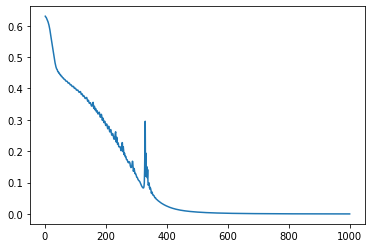

In [ ]:
plt.plot(epochs_legend, loss_list)
plt.show()

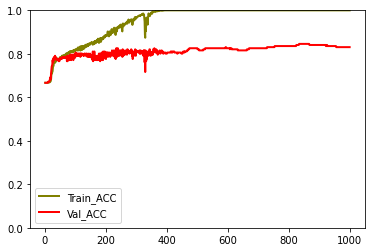

In [ ]:
axes = plt.gca()
axes.set_ylim([0,1])

plt.plot(epochs_legend, train_acc_list, marker='', color='olive', linewidth=2, label="Train_ACC")
plt.plot(epochs_legend, val_acc_list, marker='', color='red', linewidth=2, label="Val_ACC")
plt.legend()

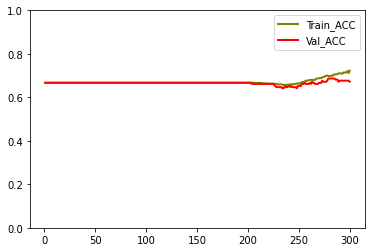

In [ ]:
axes = plt.gca()
axes.set_ylim([0,1])

plt.plot(epochs_legend, train_acc_list, marker='', color='olive', linewidth=2, label="Train_ACC")
plt.plot(epochs_legend, val_acc_list, marker='', color='red', linewidth=2, label="Val_ACC")
plt.legend()

# GAE

In [80]:
def get_roc_score(model, train_input, adj_orig, edges_pos, edges_neg, emb=None):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = model(train_input, training=False).numpy()
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])


    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [81]:
g = cuda_humannet_dgl
in_dim = input_features.shape[1]
num_hiddens = [256, 128, 64]
num_layers = len(num_hiddens)
num_classes = 2
heads = [8, 8, 8, 8]
activation = tf.keras.activations.relu
feat_drop = 0.1
attn_drop = 0.1
dropout = 0.1
negative_slope = 0.2
residual = True
norm = 'both'

In [82]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fcn = tf.nn.weighted_cross_entropy_with_logits

In [86]:
train_input = tf.convert_to_tensor(input_features, dtype=tf.float32)

In [85]:
# Data split
adj_train, train_edges, valid_pos, valid_neg, test_pos, test_neg = data_split(humannet_adj, 0.2, 0.1)

In [ ]:
class GraphAutoEncoder(tf.keras.Model):
  
    def __init__(self, adj_orig, dropout, original_dim, intermediate_dim, latent_dim, name="GCNModel"):
        super(GraphAutoEncoder, self).__init__(name=name)
        self.dropout = dropout
        self.pos_weight, self.norm = get_norm_terms(adj_orig)
        self.adj_orig_tensor = tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_orig))

        # layers
        self.graphconvolutionsparse = GraphConvolutionSparse(
            input_dim=original_dim,
            output_dim=intermediate_dim,
            dropout=self.dropout)
        self.graphconvolution = GraphConvolution(
            input_dim=intermediate_dim,
            output_dim=latent_dim,
            dropout=self.dropout)
        self.innerproductdecoder = InnerProductDecoder(
            dropout=self.dropout
        )

    def set_adj(self, adj):
        self.adj = adj

    def call(self, inputs):
        self.intermediate_latent = self.graphconvolutionsparse(self.adj, inputs)
        self.final_latent = self.graphconvolution(self.adj, self.intermediate_latent)
        self.reconstructed = self.innerproductdecoder(self.final_latent)

        # loss function
        loss = self.norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=tf.reshape(self.reconstructed, [-1]),
                                                                          labels=tf.reshape(self.adj_orig_tensor, [-1]),
                                                                          pos_weight=self.pos_weight))

        self.add_loss(loss)

        # acc function
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(self.reconstructed), 0.5), tf.int32),
                                      tf.cast(self.adj_orig_tensor, tf.int32))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.add_metric(acc, name='acc', aggregation='mean')

        return self.reconstructed

In [87]:
class GAE(tf.keras.Model):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_layers,
                 activation,
                 dropout):
        super(GAE, self).__init__()
        self.g = g
        self.layer_list = []
        # input layer
        self.layer_list.append(GraphConv(in_feats, n_hidden[0], activation=activation))
        # hidden layers
        for i in range(1, n_layers):
            self.layer_list.append(GraphConv(n_hidden[i-1], n_hidden[i], activation=activation))
        # output layer
        self.dropout = layers.Dropout(dropout)

    def call(self, features):
        h = features
        for i, layer in enumerate(self.layer_list):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        h = self.dropout(h)
        x = tf.transpose(h)
        h = tf.matmul(h, x)
        return h

In [88]:
model_gae = GAE(g, in_dim, num_hiddens, num_layers, activation, dropout)

In [89]:
logits = model_gae(train_input, training=False)

In [ ]:
weight_decay = 0.02

pos_weight = float(adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) / adj_train.sum()
norm = adj_train.shape[0] * adj_train.shape[0] / float((adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) * 2)

epochs_legend = [i+1 for i in range(500)]
loss_list = list()
train_acc_list = list()
val_roc_list = list()
val_ap_list = list()

for epoch in tqdm(range(500)):
    # forward
    with tf.GradientTape() as tape:
        tape.watch(model_gae.trainable_weights)
        logits = model_gae(train_input, training=True)

        loss_value = norm * tf.reduce_mean(loss_fcn(
            labels=tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_train)), logits=logits, pos_weight=pos_weight))
        loss_list.append(loss_value.numpy().item())
        # Manually Weight Decay
        # We found Tensorflow has a different implementation on weight decay
        # of Adam(W) optimizer with PyTorch. And this results in worse results.
        # Manually adding weights to the loss to do weight decay solves this problem.
        for weight in model_gae.trainable_weights:
            loss_value = loss_value + \
                weight_decay*tf.nn.l2_loss(weight)

        grads = tape.gradient(loss_value, model_gae.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_gae.trainable_weights))

    train_acc = accuracy_ae(logits, humannet_adj)
    train_acc_list.append(train_acc)

    roc_curr, ap_curr = get_roc_score(model_gae, train_input, humannet_adj, valid_pos, valid_neg)

    val_roc_list.append(roc_curr)
    val_ap_list.append(ap_curr)

    print("Epoch {:05d}| Loss {:.4f} | TrainAcc {:.4f} |"
          " ValAUROC {:.4f} | ValAP {:.4f}".
          format(epoch, loss_value.numpy().item(), train_acc,
                  roc_curr, ap_curr))
    

print()
# if args.early_stop:
#     model.load_weights('es_checkpoint.pb')

test_roc_curr, test_ap_curr = get_roc_score(model_gae, train_input, humannet_adj, test_pos, test_neg)
print("Test AUROC {:.4f} | Test AP {:.4f}".format(test_roc_curr, test_ap_curr))

In [ ]:
logits.shape

TensorShape([13195, 13195])

# ANN

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
y_train[0]

5

In [ ]:
train_input[train_mask]

<tf.Tensor: shape=(929, 1234), dtype=float32, numpy=
array([[1.19878609e-06, 0.00000000e+00, 3.37162169e-06, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [6.97131400e-05, 7.73373176e-06, 3.57821264e-05, ...,
        0.00000000e+00, 3.00000000e+00, 3.50000000e+00],
       [1.23707669e-05, 7.71321629e-06, 1.22705615e-05, ...,
        1.11111112e-01, 2.50000000e+00, 3.75000000e+00],
       ...,
       [1.29635708e-04, 1.55992457e-04, 1.01132857e-04, ...,
        0.00000000e+00, 1.00000000e+00, 1.75000000e+00],
       [2.63466558e-04, 2.65242474e-04, 7.40576710e-04, ...,
        0.00000000e+00, 3.00000000e+00, 3.00000000e+00],
       [1.80296856e-03, 4.37620271e-04, 1.24688784e-03, ...,
        0.00000000e+00, 0.00000000e+00, 3.33333343e-01]], dtype=float32)>

In [ ]:
label_array[train_mask].shape

(929, 2)

In [ ]:
label_array[train_mask].reshape((929,2, ))

ValueError: ignored

In [ ]:
def label_dimension_reduce(label_array):
  result = list()
  for label in label_array:
    if label[0] == 1:
      result.append(1)
    else:
      result.append(0)
  return np.array(result)

In [ ]:
feature_size = train_input.shape[1]

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(feature_size, )),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_input[train_mask], label_dimension_reduce(label_array[train_mask]), epochs=1000)

model.evaluate(train_input[test_mask],  label_dimension_reduce(label_array[test_mask]), verbose=2)

Epoch 1/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.6472
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6246 - accuracy: 0.6647
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6278 - accuracy: 0.6433
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6139 - accuracy: 0.6874
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6165 - accuracy: 0.6490
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.6795
Epoch 7/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6211 - accuracy: 0.6756
Epoch 8/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.6762
Epoch 9/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.5944 - accuracy: 0.7097
Epoch 10/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.6589

[1.7734887599945068, 0.5990098714828491]